In [1]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader

#Model

In [2]:
class MLP(nn.Module):
  def __init__(self):
    super().__init__()

    self.net = nn.Sequential(
        nn.Linear(6,64),
        nn.Tanh(),
        nn.Linear(64,64),
        nn.Tanh(),
        nn.Linear(64,64),
        nn.Tanh(),
        nn.Linear(64,4)
    )

  def forward(self,x):
    return self.net(x)

#Training

In [3]:
def load_double_pendulum(format):
    #chemin_data_train = Path(__file__).parent.parent / 'data' / 'double_pendulum_train2.npz'
    #chemin_data_test = Path(__file__).parent.parent / 'data' / 'double_pendulum_test2.npz'

    data_train = np.load("double_pendulum_train2.npz")
    data_test = np.load("double_pendulum_test2.npz")

    if format in ["sincos"]:
        theta1_train = data_train["theta1"]
        theta2_train = data_train["theta2"]
        omega1_train = data_train["omega1"]
        omega2_train = data_train["omega2"]

        #omega1_train = (omega1_train - omega1_train.mean())/omega1_train.std()
        #omega2_train = (omega2_train - omega2_train.mean())/omega2_train.std()
        X_train = np.stack([np.sin(theta1_train), np.cos(theta1_train), np.sin(theta2_train), np.cos(theta2_train), omega1_train, omega2_train], axis=1)
        dx_train = np.stack([data_train["dtheta1"], data_train["dtheta2"], data_train["domega1"], data_train["domega2"]], axis=1)

        theta1_test = data_test["theta1"]
        theta2_test = data_test["theta2"]
        omega1_test = data_test["omega1"]
        omega2_test = data_test["omega2"]

        #omega1_test = (omega1_test - omega1_test.mean())/omega1_test.std()
        #omega2_test = (omega2_test - omega2_test.mean())/omega2_test.std()

        X_test = np.stack([np.sin(theta1_test), np.cos(theta1_test), np.sin(theta2_test), np.cos(theta2_test), omega1_test, omega2_test], axis=1)
        dx_test = np.stack([data_test["dtheta1"], data_test["dtheta2"], data_test["domega1"], data_test["domega2"]], axis=1)

    elif format in ["theta"]:
        X_train = np.stack([data_train["theta1"], data_train["theta2"], data_train["omega1"], data_train["omega2"]], axis=1)
        dx_train = np.stack([data_train["dtheta1"], data_train["dtheta2"], data_train["domega1"], data_train["domega2"]], axis=1)

        X_test = np.stack([data_test["theta1"], data_test["theta2"], data_test["omega1"], data_test["omega2"]], axis=1)
        dx_test = np.stack([data_test["dtheta1"], data_test["dtheta2"], data_test["domega1"], data_test["domega2"]], axis=1)

    else:
        raise ValueError("Unknown format")

    X_train = torch.tensor(X_train, dtype=torch.float32)
    dx_train = torch.tensor(dx_train, dtype=torch.float32)

    X_test = torch.tensor(X_test, dtype=torch.float32)
    dx_test = torch.tensor(dx_test, dtype=torch.float32)

    train_dataset = TensorDataset(X_train, dx_train)
    train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)

    test_dataset = TensorDataset(X_test, dx_test)
    test_loader = DataLoader(test_dataset, batch_size=512, shuffle=False)

    return train_loader, test_loader

In [4]:
#---------
#  Model
#---------

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

model = MLP().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
loss_fn = nn.MSELoss()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=50)


#----------------
# Training loop
#----------------

format = "sincos"
alpha = 0.1

train_loader, test_loader = load_double_pendulum(format)
n_epochs = 2000

for epoch in range(n_epochs):
  model.train()
  train_loss = 0.0

  for X_batch, Y_batch in train_loader:
    X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)

    dx = model(X_batch)
    dtheta1_pred = dx[:,0]
    dtheta2_pred = dx[:,1]
    domega1_pred = dx[:,2]
    domega2_pred = dx[:,3]

    loss = (
        loss_fn(dtheta1_pred, Y_batch[:,0]) +
        loss_fn(dtheta2_pred, Y_batch[:,1]) +
        alpha * loss_fn(domega1_pred, Y_batch[:,2]) +
        alpha * loss_fn(domega2_pred, Y_batch[:,3])
        )

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    train_loss += loss.item()

  train_loss /= len(train_loader)

  model.eval()

  test_loss = 0.0
  for X_batch, Y_batch in test_loader:
    X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
    dx = model(X_batch)
    dtheta1_pred = dx[:,0]
    dtheta2_pred = dx[:,1]
    domega1_pred = dx[:,2]
    domega2_pred = dx[:,3]

    loss = (
        loss_fn(dtheta1_pred, Y_batch[:,0]) +
        loss_fn(dtheta2_pred, Y_batch[:,1]) +
        alpha * loss_fn(domega1_pred, Y_batch[:,2]) +
        alpha * loss_fn(domega2_pred, Y_batch[:,3])
        )


    test_loss += loss.item()

  test_loss /= len(test_loader)
  scheduler.step(test_loss)

  if epoch % 10 == 0:
    print(f"Epoch {epoch+1}/{n_epochs}, Train Loss: {train_loss:.6f}, Test Loss: {test_loss:.6f}")

#-------------
# Save model
#-------------

torch.save({
    "model": "mlp",
    "state_dict": model.state_dict(),
    "epochs": 2000,
    "lr": 3e-4
    }, "mlp.pth")

Using device: cpu
Epoch 1/2000, Train Loss: 96.525189, Test Loss: 96.284128
Epoch 11/2000, Train Loss: 76.306523, Test Loss: 77.816320
Epoch 21/2000, Train Loss: 68.858465, Test Loss: 70.068930
Epoch 31/2000, Train Loss: 57.052360, Test Loss: 58.520382
Epoch 41/2000, Train Loss: 50.786528, Test Loss: 52.781308
Epoch 51/2000, Train Loss: 47.225871, Test Loss: 49.220469
Epoch 61/2000, Train Loss: 44.076515, Test Loss: 46.355509
Epoch 71/2000, Train Loss: 41.300341, Test Loss: 43.599710
Epoch 81/2000, Train Loss: 37.764860, Test Loss: 40.369958
Epoch 91/2000, Train Loss: 33.782648, Test Loss: 35.931039
Epoch 101/2000, Train Loss: 29.558221, Test Loss: 31.578273
Epoch 111/2000, Train Loss: 25.585646, Test Loss: 27.394931
Epoch 121/2000, Train Loss: 22.371404, Test Loss: 23.882884
Epoch 131/2000, Train Loss: 19.869297, Test Loss: 21.188787
Epoch 141/2000, Train Loss: 17.799948, Test Loss: 19.054698
Epoch 151/2000, Train Loss: 16.042352, Test Loss: 17.524482
Epoch 161/2000, Train Loss: 14.61

#Results

In [5]:
def double_pendulum_dynamics(X, params):  # Compute the function f(x,t) such that theta'' = f(x,t)
  if X.dim() == 1:
      X = X.unsqueeze(0)
  theta1, theta2, omega1, omega2 = X[:,0], X[:,1], X[:,2], X[:,3]
  m, l, g = params["m"], params["l"], params["g"]

  omega1_dot = (-g * (2 * torch.sin(theta1) - torch.sin(theta2) * torch.cos(theta1 - theta2)) - torch.sin(theta1 - theta2) * (omega2**2 * l + omega1**2 * l * torch.cos(theta1 - theta2))) / (l * (2 - torch.cos(theta1 - theta2)**2))
  omega2_dot = (2 * torch.sin(theta1 - theta2) * (omega1**2 * l * (1) + g * torch.cos(theta1)) + omega2**2 * l * torch.sin(theta1 - theta2) * torch.cos(theta1 - theta2)) / (l * (2 - torch.cos(theta1 - theta2)**2))

  dX = torch.stack([omega1, omega2, omega1_dot, omega2_dot], dim=1)
  if X.dim() == 1:
      dX = dX.squeeze(0)
  return dX

def rk4_step(f, x, dt, params):  # Compute the position after a short time dt based on the pervious position using rk4 method
  dt_tensor = torch.tensor(dt, dtype=torch.float64)

  k1 = f(x, params)
  k2 = f(x + 0.5 * dt_tensor * k1, params)
  k3 = f(x + 0.5 * dt_tensor * k2, params)
  k4 = f(x + dt_tensor * k3, params)

  return x + (dt_tensor / 6) * (k1 + 2*k2 + 2*k3 + k4)

def trajectory_simulation(x0, dt, T, params):
  N = int(T/dt)
  x = torch.zeros((N+1, 4), dtype=torch.float64)
  x[0] = torch.tensor(x0, dtype=torch.float64)

  for t in range(N):
   x[t+1] = rk4_step(double_pendulum_dynamics, x[t], dt, params)
  return x.numpy() # Convert the final trajectory back to a numpy array

def model_input_double_pendulum(x,format):
  if not isinstance(x, torch.Tensor):
    x = torch.tensor(x, dtype=torch.float32)

  if x.dim() == 1:
    x = x.unsqueeze(0)

  if format == "sincos":
      sin1 = torch.sin(x[:,0]).unsqueeze(1)
      cos1 = torch.cos(x[:,0]).unsqueeze(1)
      sin2 = torch.sin(x[:,1]).unsqueeze(1)
      cos2 = torch.cos(x[:,1]).unsqueeze(1)
      omega1 = x[:,2].unsqueeze(1)
      omega2 = x[:,3].unsqueeze(1)
      x = torch.cat([sin1, cos1, sin2, cos2, omega1, omega2], dim=1)
  return x

def simulate(model, x0, dt, T, format):
    n_steps = int(T / dt)
    traj = []

    x = torch.tensor(x0, dtype=torch.float32)
    if x.dim() == 1:
        x = x.unsqueeze(0)

    for _ in range(n_steps + 1):
        traj.append(x.clone().detach())

        k1 = model(model_input_double_pendulum(x, format)).detach()
        k2 = model(model_input_double_pendulum(x + dt/2 * k1, format)).detach()
        k3 = model(model_input_double_pendulum(x + dt/2 * k2, format)).detach()
        k4 = model(model_input_double_pendulum(x + dt * k3, format)).detach()

        x = x + dt/6 * (k1 + 2*k2 + 2*k3 + k4)

    return torch.cat(traj, dim=0).cpu().numpy()

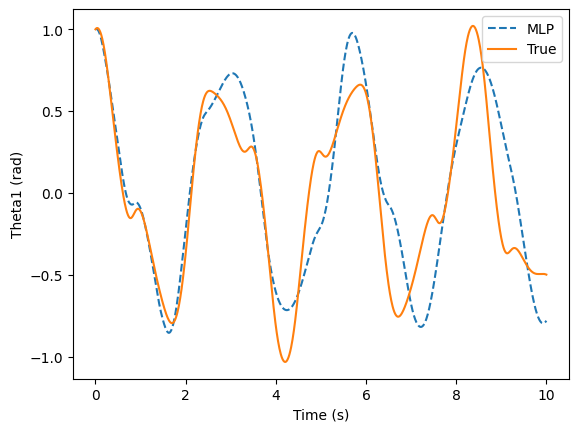

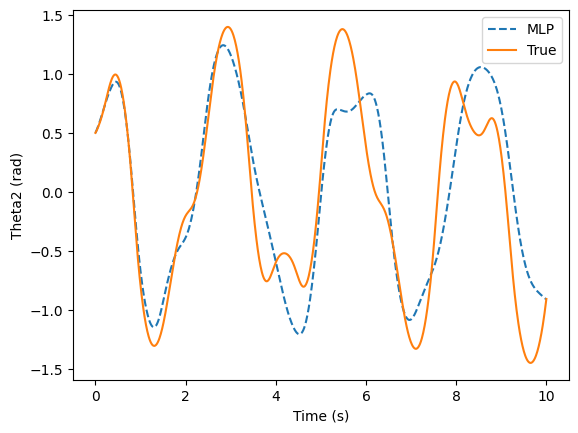

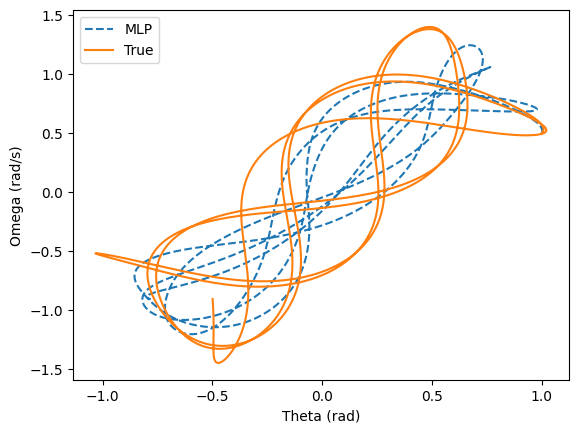

In [6]:
#--------------
# Parameters
#--------------

params = {
    "g": 9.81,   # gravity (m/s^2)
    "l": 1.0,    # lenght (m)
    "m": 1.0     # mass (kg)
}

theta1 = 1.0
theta2 = 0.5
omega1 = 0.4
omega2 = 0.7

x0 = [theta1, theta2, omega1, omega2]
mlp_trajectory = []
true_trajectory = []
T = 10 # 5s
dt = 0.01 # 500 step

#--------------
# Trajectories
#--------------

mlp_trajectory = simulate(model, x0, dt, T, "sincos")
true_trajectory = trajectory_simulation(x0, dt, T, params)

#-------
# Plot
#-------

t = np.arange(start = 0, stop = T + dt/2, step = dt)

plt.plot(t, np.array(mlp_trajectory)[:,0], "--")
plt.plot(t, np.array(true_trajectory)[:,0])
plt.xlabel("Time (s)")
plt.ylabel("Theta1 (rad)")
plt.legend(["MLP", "True"])
plt.show()
plt.figure()
plt.plot(t, np.array(mlp_trajectory)[:,1], "--")
plt.plot(t, np.array(true_trajectory)[:,1])
plt.xlabel("Time (s)")
plt.ylabel("Theta2 (rad)")
plt.legend(["MLP", "True"])
plt.show()

plt.figure()
plt.plot(np.array(mlp_trajectory)[:,0], np.array(mlp_trajectory)[:,1], "--")
plt.plot(np.array(true_trajectory)[:,0], np.array(true_trajectory)[:,1])
plt.legend(["MLP", "True"])
plt.xlabel("Theta (rad)")
plt.ylabel("Omega (rad/s)")
plt.show()

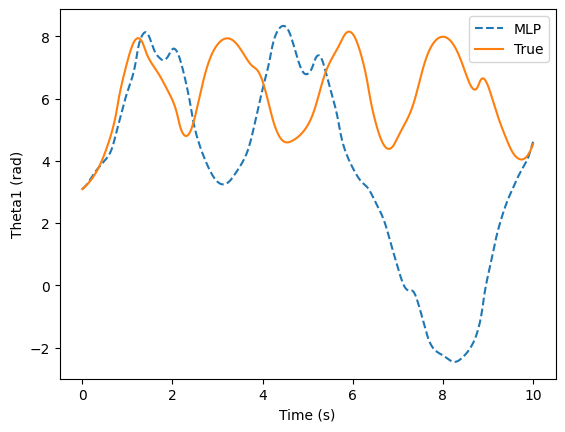

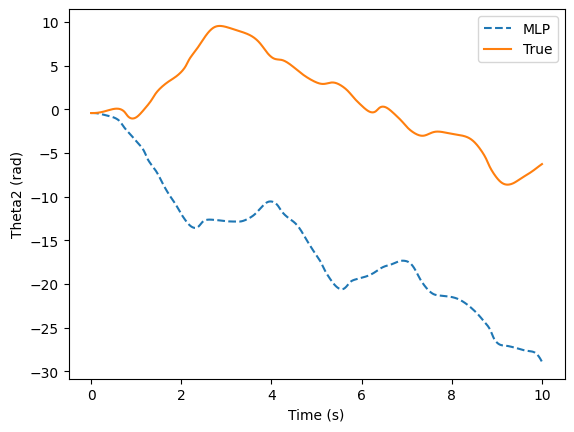

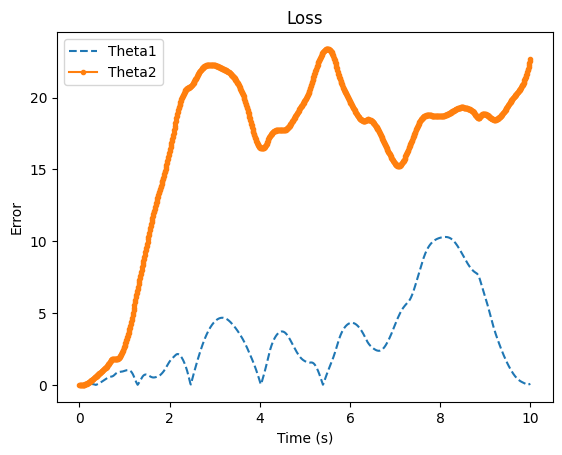

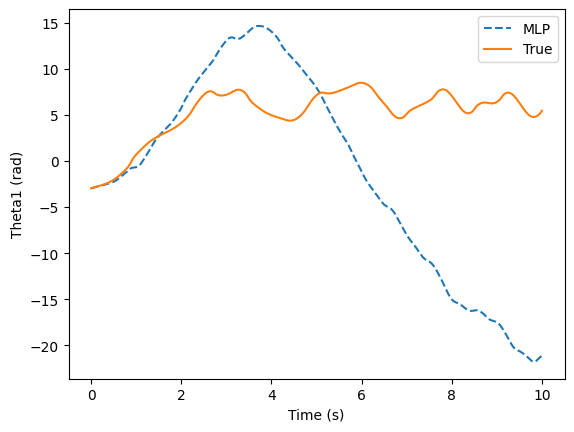

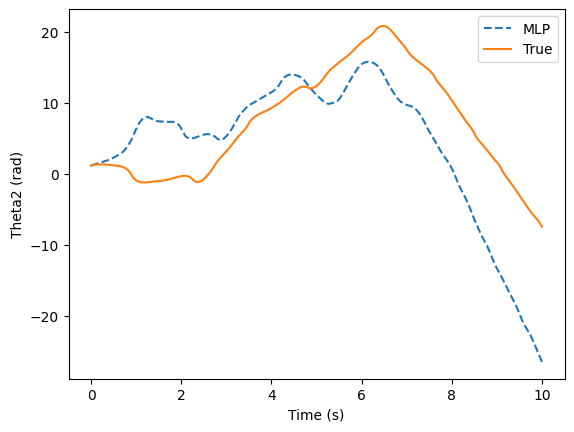

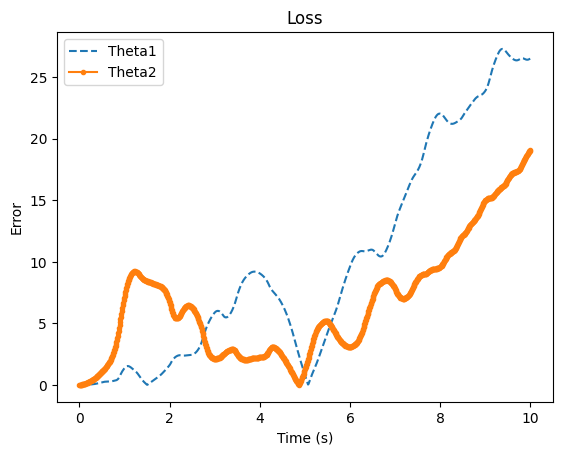

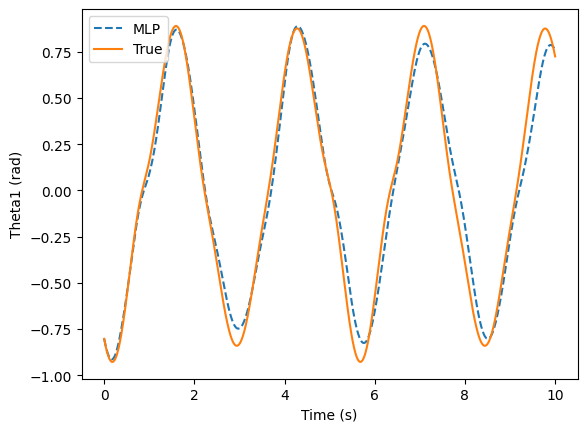

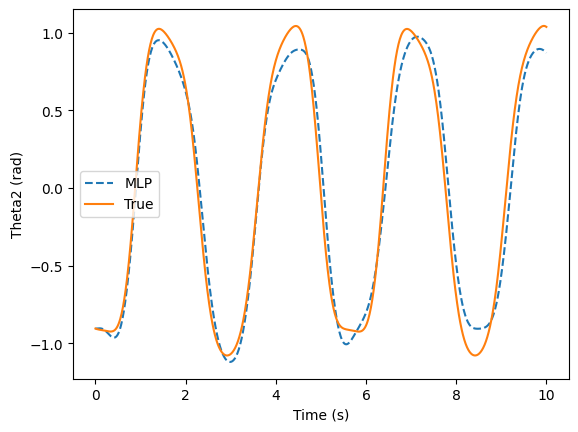

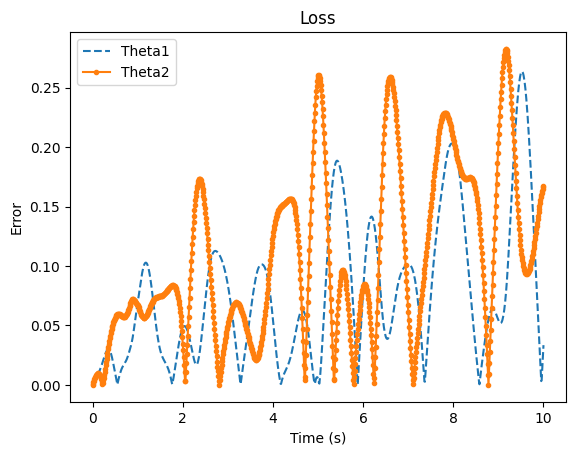

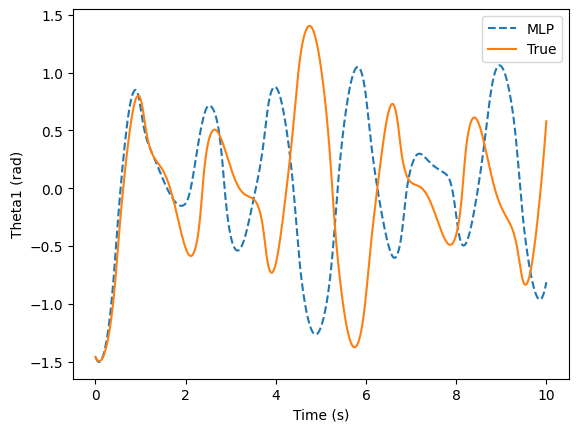

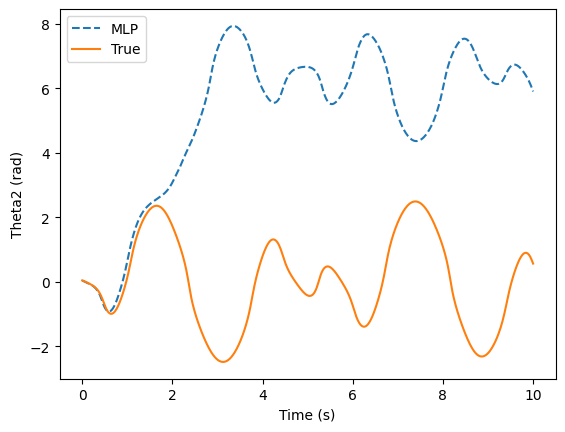

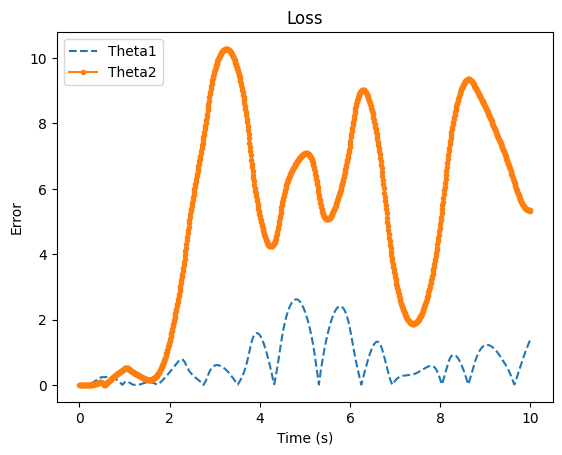

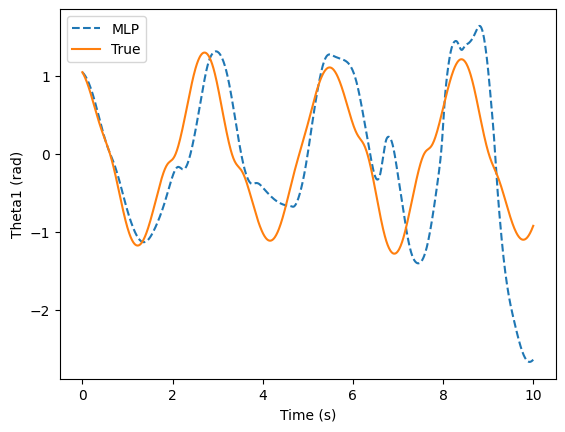

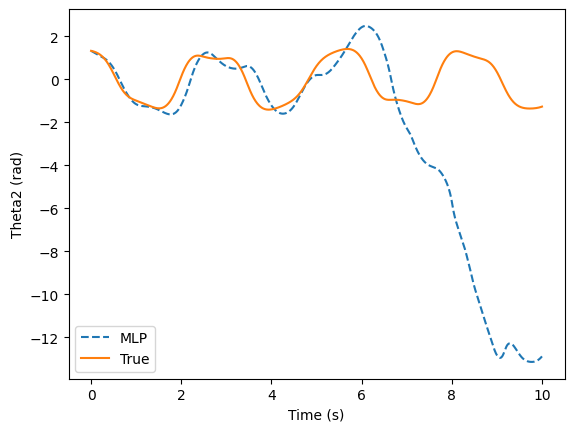

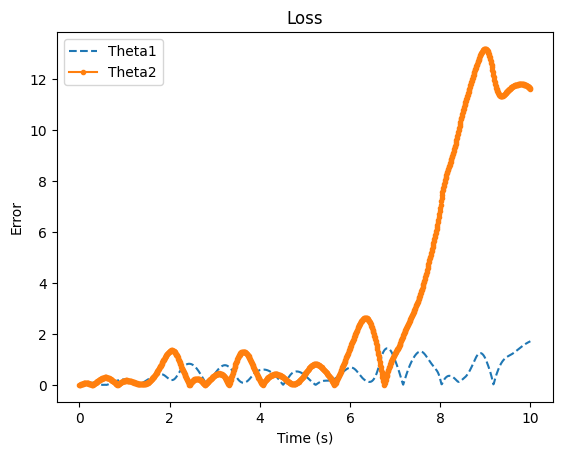

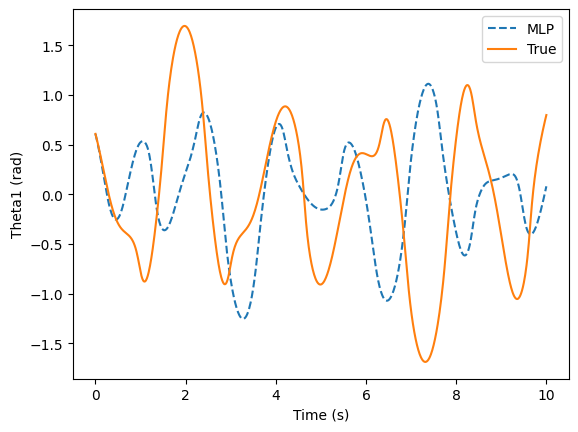

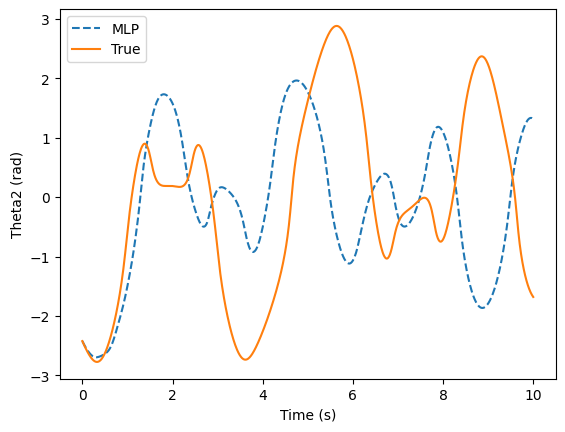

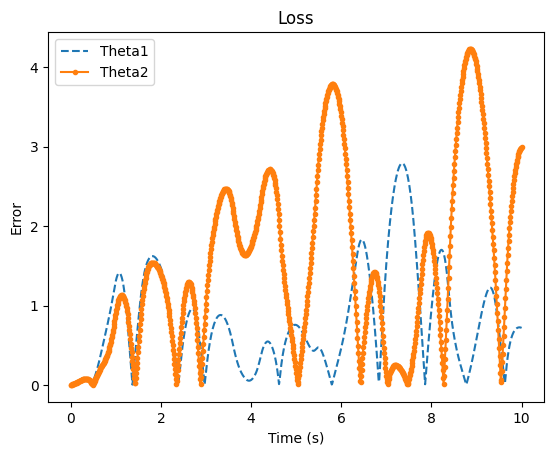

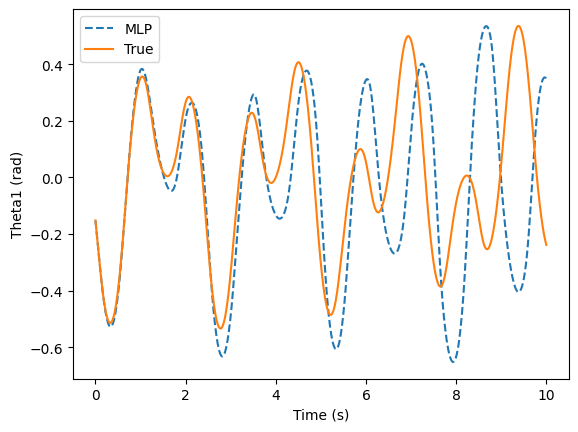

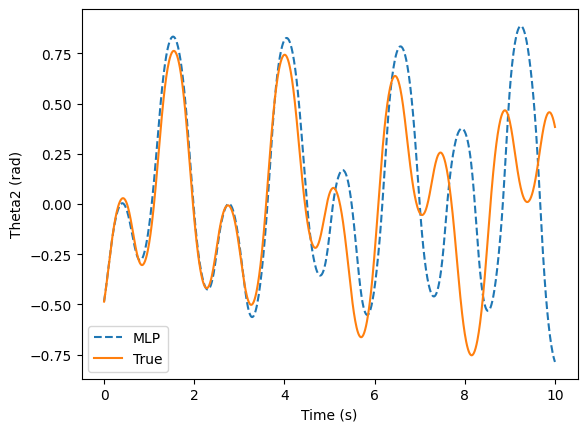

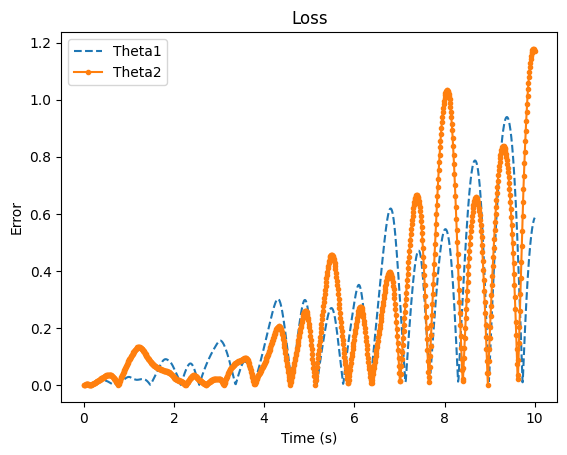

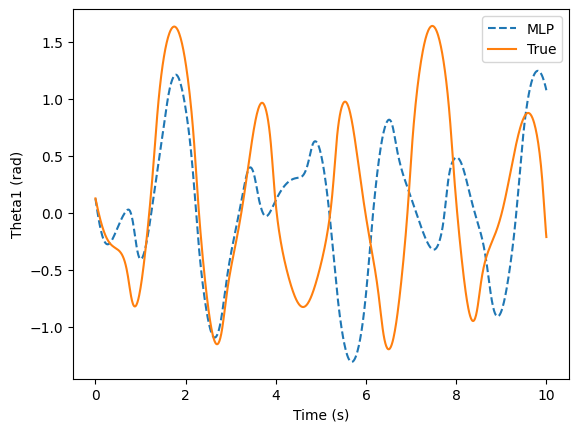

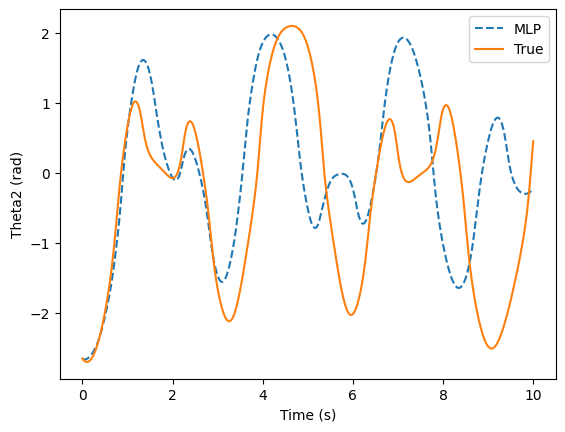

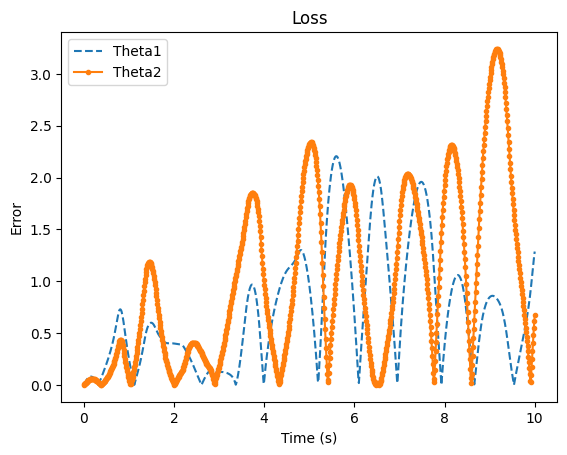

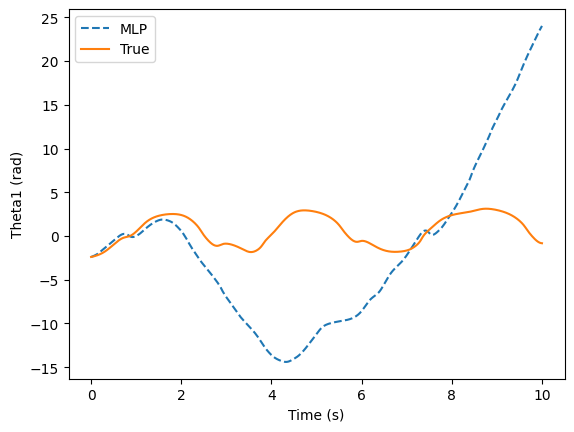

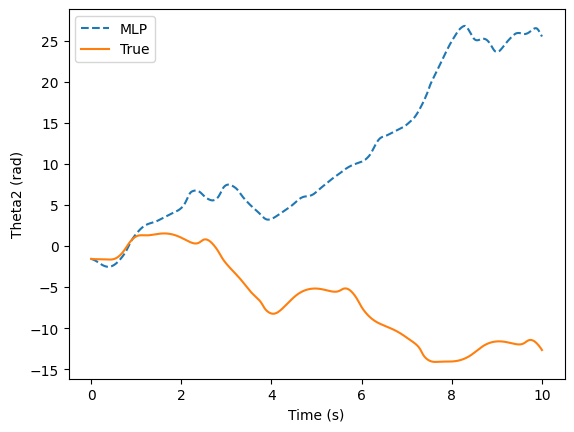

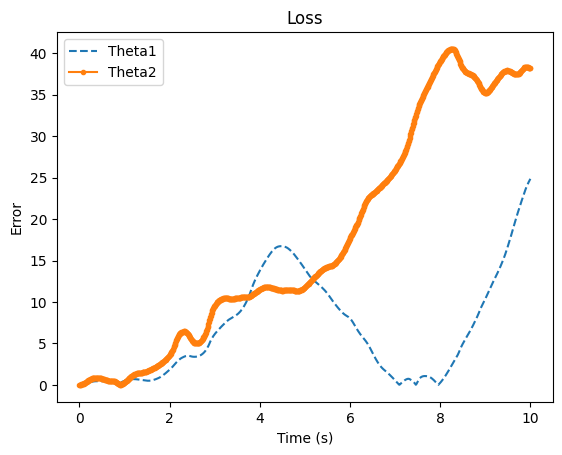

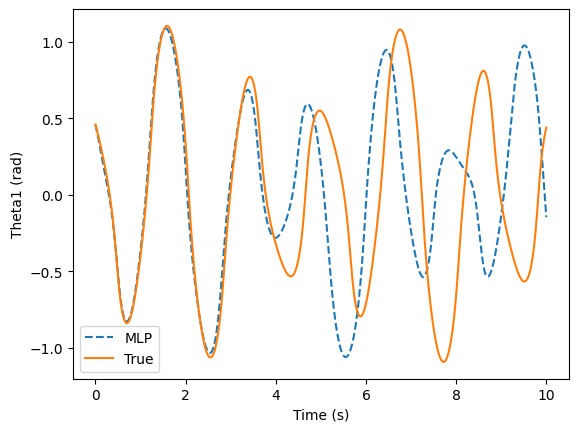

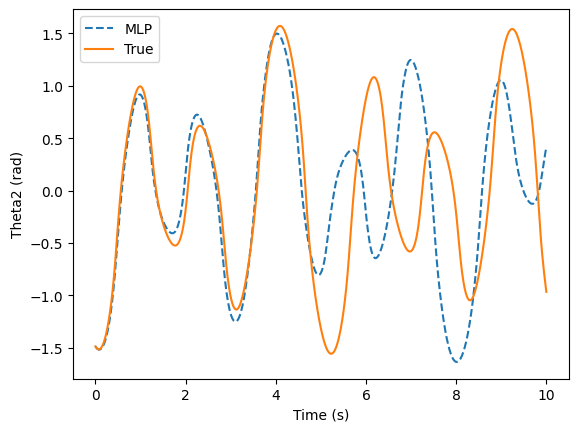

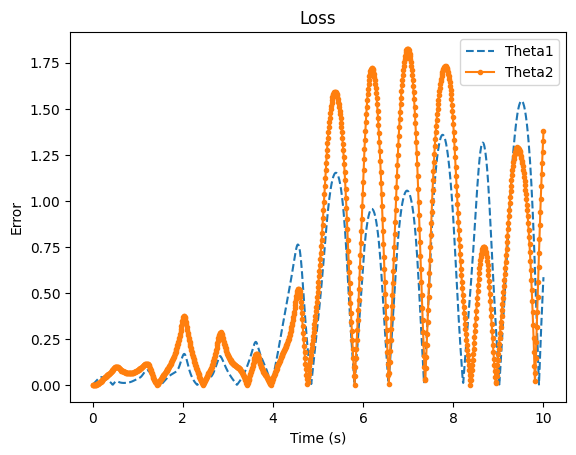

In [7]:
for k in range(10):
  theta1 = np.random.uniform(-np.pi, np.pi)
  theta2 = np.random.uniform(-np.pi, np.pi)
  omega1 = np.random.uniform(-2.0,2.0)
  omega2 = np.random.uniform(-2.0,2.0)

  x0 = [theta1, theta2, omega1, omega2]

  mlp_trajectory = simulate(model, x0, dt, T, "sincos")
  true_trajectory = trajectory_simulation(x0, dt, T, params)
  error_0 = np.abs(mlp_trajectory[:,0] - true_trajectory[:,0])
  error_1 = np.abs(mlp_trajectory[:,1] - true_trajectory[:,1])

  plt.plot(t, np.array(mlp_trajectory)[:,0], "--")
  plt.plot(t, np.array(true_trajectory)[:,0])
  plt.xlabel("Time (s)")
  plt.ylabel("Theta1 (rad)")
  plt.legend(["MLP", "True"])
  plt.show()

  plt.figure()
  plt.plot(t, np.array(mlp_trajectory)[:,1], "--")
  plt.plot(t, np.array(true_trajectory)[:,1])
  plt.xlabel("Time (s)")
  plt.ylabel("Theta2 (rad)")
  plt.legend(["MLP", "True"])
  plt.show()

  plt.figure()
  plt.plot(t, error_0, "--")
  plt.plot(t, error_1, ".-")
  plt.xlabel("Time (s)")
  plt.ylabel("Error")
  plt.title("Loss")
  plt.legend(["Theta1", "Theta2"])
  plt.show()